In [1]:
# Configuración inicial
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [2]:
# Descargar los datos
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file) / "spa-eng" / "spa.txt"

In [3]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [4]:
for _ in range(5):
    print(random.choice(text_pairs))

('She fell from the tree.', '[start] Ella cayó del árbol. [end]')
('She watched the passengers get off the bus.', '[start] Ella miraba a los pasajeros bajarse del bus. [end]')
('I want to know how much money I should bring with me.', '[start] Quiero saber cuanto dinero traer conmigo. [end]')
('I found the comic book very interesting.', '[start] Encuentro el comic muy interesante. [end]')
('You will never defeat me!', '[start] ¡Nunca me derrotarás! [end]')


In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [7]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-03-22 14:26:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.78MB/s    in 8m 8s   

2025-03-22 14:34:59 (1.68 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [7]:
# Cargar embeddings preentrenados de GloVe
embedding_dim = 300  # Dimensión de los embeddings de GloVe
embeddings_index = {}
with open("glove.6B.300d.txt", encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

# Crear matriz de embeddings para el vocabulario de inglés
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(eng_vectorization.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [9]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [10]:
import matplotlib.pyplot as plt
import numpy as np


# Modificar TransformerEncoder para devolver los pesos de atención
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output, attention_scores = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask, return_attention_scores=True
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output), attention_scores

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

# Modificar TransformerDecoder para devolver los pesos de atención
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1, attention_scores_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
            return_attention_scores=True
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2, attention_scores_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
            return_attention_scores=True
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output), attention_scores_1, attention_scores_2

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

embed_dim = 300 #256
latent_dim = 2048
num_heads = 8

# Ensamblar el modelo con las modificaciones
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

# Crear un encoder con 6 capas
#encoder_outputs = encoder_inputs
#for _ in range(6):
#    encoder_outputs, _ = TransformerEncoder(embed_dim, latent_dim, num_heads)(encoder_outputs)

encoder_outputs, encoder_attention_scores = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, [encoder_outputs, encoder_attention_scores])

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x, decoder_attention_scores_1, decoder_attention_scores_2 = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)

# Crear un decoder con 6 capas
#decoder_outputs = decoder_inputs
#for _ in range(6):
#    decoder_outputs, _, _ = TransformerDecoder(embed_dim, latent_dim, num_heads)([decoder_outputs, encoder_outputs])

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], [decoder_outputs, decoder_attention_scores_1, decoder_attention_scores_2])

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    [decoder_outputs, decoder_attention_scores_1, decoder_attention_scores_2],
    name="transformer",
)

# Asignar los embeddings preentrenados de GloVe a la capa de embeddings del encoder
embedding_layer = transformer.get_layer("positional_embedding").token_embeddings
embedding_layer.set_weights([embedding_matrix])
embedding_layer.trainable = False  # Congelar los embeddings


epochs = 50

from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

optimizer = RMSprop(learning_rate=0.0001)  # Prueba con una tasa de aprendizaje más baja
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

from keras.optimizers.schedules import ExponentialDecay

#initial_learning_rate = 0.0001
#lr_scheduler = ExponentialDecay(
#    initial_learning_rate, decay_steps=10000, decay_rate=0.95, staircase=True
#)
#optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo (esto no cambia)
transformer.summary()
transformer.compile(
    optimizer=optimizer,
    #"rmsprop",
    #loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    #loss={"decoder_outputs": keras.losses.SparseCategoricalCrossentropy(ignore_class=0)},
    loss=[keras.losses.SparseCategoricalCrossentropy(ignore_class=0), None, None],  # Solo aplicamos pérdida a la primera salida
    loss_weights=[1.0, 0.0, 0.0],  # Solo aplicamos pérdida a la primera salida
    metrics=[["accuracy"], None, None],
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 300)      │      4,506,000 │ encoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 300)      │      4,506,000 │ decoder_inputs[0][0]   │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ [(None, None, 300),    │      4,119,848 │ positional_embedding[… │
│ (TransformerEncoder)      │ (None, 8, None, None)] │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ [(None, None, 300),    │      7,007,948 │ positional_embedding_… │
│ (TransformerDecoder)      │ (None, 8, None, None), │                │ transformer_encoder[0… │
│                           │ (None, 8, None, None)] │                │ not_equal_1[0][0],     │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 300)      │              0 │ transformer_decoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, None, 15000)    │      4,515,000 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,654,796 (94.05 MB)

 Trainable params: 20,154,796 (76.88 MB)

 Non-trainable params: 4,500,000 (17.17 MB)

Epoch 1/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 130s 86ms/step - dense_4_accuracy: 0.0598 - loss: 10.2250 - val_dense_4_accuracy: 0.1067 - val_loss: 4.8702 - learning_rate: 1.0000e-04
Epoch 2/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 117s 76ms/step - dense_4_accuracy: 0.1152 - loss: 4.7786 - val_dense_4_accuracy: 0.1445 - val_loss: 4.0496 - learning_rate: 1.0000e-04
Epoch 3/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 98s 76ms/step - dense_4_accuracy: 0.1472 - loss: 4.0204 - val_dense_4_accuracy: 0.1689 - val_loss: 3.4927 - learning_rate: 1.0000e-04
Epoch 4/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 148s 80ms/step - dense_4_accuracy: 0.1658 - loss: 3.5574 - val_dense_4_accuracy: 0.1833 - val_loss: 3.1506 - learning_rate: 1.0000e-04
Epoch 5/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 98s 75ms/step - dense_4_accuracy: 0.1795 - loss: 3.2361 - val_dense_4_accuracy: 0.1926 - val_loss: 2.9267 - learning_rate: 1.0000e-04
Epoch 6/50
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 103s 79ms/step - dense_4_accuracy: 0.1896 - loss: 3.0129 - val_dense_4_acc

In [11]:
# Guardar el modelo
transformer.save("transformer_model.keras")

In [12]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions, _, _ = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)

She always speaks to him in a loud voice. [start] ella siempre habla con él en voz alta [end]
She didn't accept the invitation. [start] ella no aceptó la invitación [end]
He isn't perfect. [start] Él no es perfecto [end]
I woke up at sunrise. [start] me desperté en el momento [end]
Hold on a sec. [start] [UNK] una [UNK] [end]
Tom chose to ignore Mary's comment. [start] tom decidió [UNK] la tarde de mary [end]
Tom didn't look like a freak. [start] tom no se le gustaba un [UNK] [end]
Tom passed most of the time fishing. [start] tom murió la de la mayoría de tiempo [end]
It just came out. [start] solo se salió [end]
Can you give me an explanation? [start] puedes darme una explicación [end]
I'm not optimistic. [start] no estoy [UNK] [end]
How long will you be at your aunt's house? [start] cuánto tiempo vas a estar en la casa de tu tía [end]
You're going to screw this up. [start] vas a [UNK] esto [end]
I thought you'd be thrilled. [start] pensé que [UNK] [UNK] [end]
I don't want to remember

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


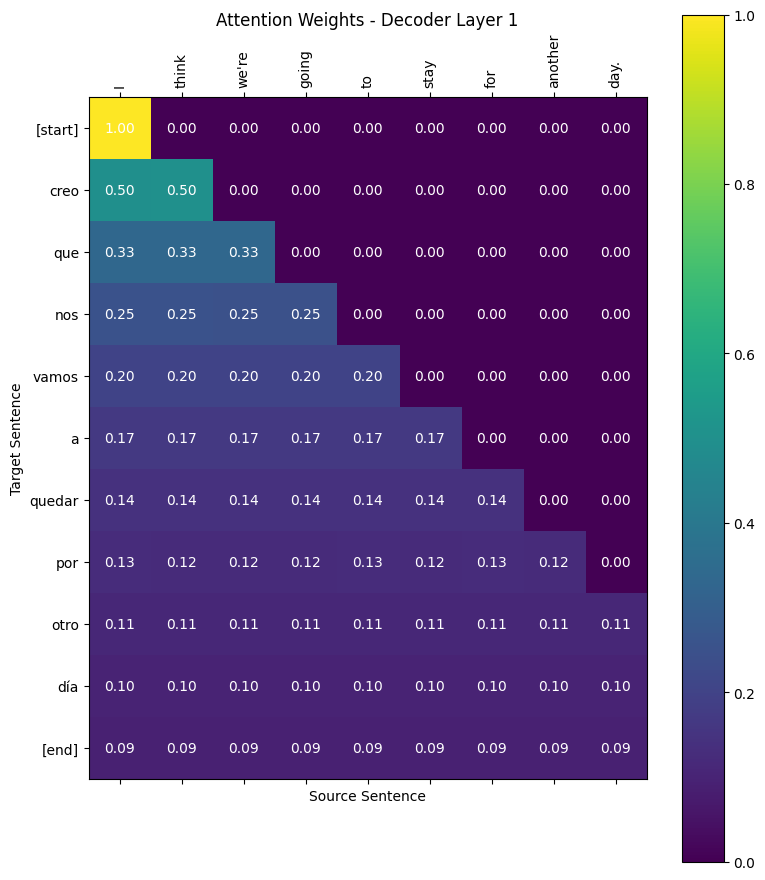

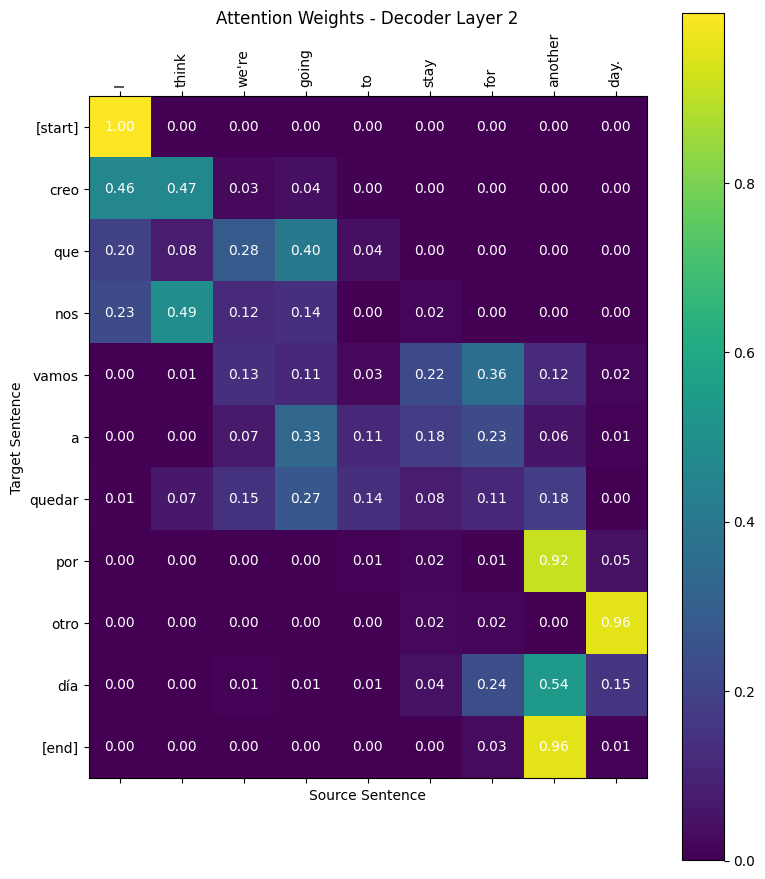

In [21]:
# Función para visualizar los pesos de atención con tamaño dinámico
def plot_attention_weights(attention_scores, source_sentence, target_sentence, layer_name):
    # Obtener las palabras de las frases
    source_words = source_sentence.split()
    target_words = target_sentence.split()

    # Recortar la matriz de atención al tamaño de las frases
    attention_scores = attention_scores[0]  # Seleccionar el primer elemento del batch
    attention_scores = attention_scores[:len(target_words), :len(source_words)]  # Recortar la matriz

    # Crear el heatmap
    fig, ax = plt.subplots(figsize=(len(source_words), len(target_words)))  # Tamaño dinámico
    cax = ax.matshow(attention_scores, cmap='viridis')

    # Configurar ejes
    ax.set_xticks(range(len(source_words)))
    ax.set_yticks(range(len(target_words)))
    ax.set_xticklabels(source_words, rotation=90)
    ax.set_yticklabels(target_words)

    # Mostrar los valores de los attention_scores en cada celda
    for i in range(len(target_words)):
        for j in range(len(source_words)):
            ax.text(j, i, f"{attention_scores[i, j]:.2f}", ha="center", va="center", color="white")

    # Añadir etiquetas y título
    ax.set_xlabel("Source Sentence")
    ax.set_ylabel("Target Sentence")
    ax.set_title(f"Attention Weights - {layer_name}")

    # Añadir barra de color
    fig.colorbar(cax)
    plt.show()

# Probar con una frase de ejemplo
input_sentence = random.choice(test_eng_texts)
#print("Input Sentence:", input_sentence)
translated_sentence = decode_sequence(input_sentence)

# Obtener los pesos de atención
_, decoder_attention_scores_1, decoder_attention_scores_2 = transformer.predict({
    "encoder_inputs": eng_vectorization([input_sentence]),
    "decoder_inputs": spa_vectorization([translated_sentence])[:, :-1]
})

# Visualizar los pesos de atención
plot_attention_weights(decoder_attention_scores_1[0], input_sentence, translated_sentence, "Decoder Layer 1")
plot_attention_weights(decoder_attention_scores_2[0], input_sentence, translated_sentence, "Decoder Layer 2")

In [22]:
pip install nltk rouge

In [23]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# Función para calcular el score BLEU
def calculate_bleu(reference, candidate):
    smoothing = SmoothingFunction().method1  # Usar una función de suavizado
    return sentence_bleu([reference], candidate, smoothing_function=smoothing)

# Función para calcular el score ROUGE
def calculate_rouge(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(" ".join(candidate), " ".join(reference))
    return scores[0]  # Devuelve el diccionario de scores

# Ejemplo de uso
reference = ["this", "is", "a", "test"]
candidate = ["this", "is", "a", "test"]

bleu_score = calculate_bleu(reference, candidate)
rouge_score = calculate_rouge(reference, candidate)

print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Score: {rouge_score}")

BLEU Score: 1.0
ROUGE Score: {'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}


In [24]:
# Función para evaluar el modelo con BLEU y ROUGE en un subconjunto
def evaluate_model(model, test_pairs, eng_vectorization, spa_vectorization, num_samples=100):
    bleu_scores = []
    rouge_scores = []

    # Limitar el número de muestras a evaluar
    test_subset = test_pairs[:num_samples]

    for eng, spa in test_subset:
        # Traducir la frase en inglés
        translated_sentence = decode_sequence(eng)
        translated_tokens = translated_sentence.split()

        # Obtener la referencia (frase en español sin [start] y [end])
        reference_tokens = spa.replace("[start]", "").replace("[end]", "").split()

        # Calcular BLEU y ROUGE
        bleu_score = calculate_bleu(reference_tokens, translated_tokens)
        rouge_score = calculate_rouge(reference_tokens, translated_tokens)

        bleu_scores.append(bleu_score)
        rouge_scores.append(rouge_score)

    # Calcular promedios
    avg_bleu = np.mean(bleu_scores)
    #avg_rouge = {key: np.mean([score[key] for score in rouge_scores]) for key in rouge_scores[0].keys()}

    avg_rouge = {
        metric: np.mean([score[metric]['f'] for score in rouge_scores])
        for metric in rouge_scores[0].keys()
    }

    return avg_bleu, avg_rouge

# Evaluar el modelo en un subconjunto de 100 frases
avg_bleu, avg_rouge = evaluate_model(transformer, test_pairs, eng_vectorization, spa_vectorization, num_samples=100)
print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE Score: {avg_rouge}")

Average BLEU Score: 0.09559299695904923
Average ROUGE Score: {'rouge-1': np.float64(0.37313894467530245), 'rouge-2': np.float64(0.226229737166373), 'rouge-l': np.float64(0.3656191034054612)}


In [ ]:
# Función para evaluar el modelo con BLEU y ROUGE con todos los elementos del conjunto TEST
def evaluate_model(model, test_pairs, eng_vectorization, spa_vectorization):
    bleu_scores = []
    rouge_scores = []

    for eng, spa in test_pairs:
        # Traducir la frase en inglés
        translated_sentence = decode_sequence(eng)
        translated_tokens = translated_sentence.split()

        # Obtener la referencia (frase en español sin [start] y [end])
        reference_tokens = spa.replace("[start]", "").replace("[end]", "").split()

        # Calcular BLEU y ROUGE
        bleu_score = calculate_bleu(reference_tokens, translated_tokens)
        rouge_score = calculate_rouge(reference_tokens, translated_tokens)

        bleu_scores.append(bleu_score)
        rouge_scores.append(rouge_score)

    # Calcular promedios
    avg_bleu = np.mean(bleu_scores)
    avg_rouge = {key: np.mean([score[key] for score in rouge_scores]) for key in rouge_scores[0].keys()}

    return avg_bleu, avg_rouge

# Evaluar el modelo
avg_bleu, avg_rouge = evaluate_model(transformer, test_pairs, eng_vectorization, spa_vectorization)
print(f"Average BLEU Score: {avg_bleu}")
print(f"Average ROUGE Score: {avg_rouge}")

In [25]:
# Modelo auxiliar que devuelve las predicciones y los attention_scores
auxiliary_model = keras.Model(
    inputs=transformer.input,
    outputs=[transformer.output[0], transformer.output[1], transformer.output[2]],
    name="auxiliary_model"
)

In [26]:
# Guardar el modelo principal
transformer.save('transformer_model.keras')

# Guardar el modelo auxiliar
auxiliary_model.save('auxiliary_model.keras')

In [27]:
from tensorflow.keras.models import load_model

# Cargar el modelo principal
loaded_transformer = load_model('transformer_model.keras', custom_objects={
    'TransformerEncoder': TransformerEncoder,
    'TransformerDecoder': TransformerDecoder,
    'PositionalEmbedding': PositionalEmbedding
})

# Cargar el modelo auxiliar
loaded_auxiliary_model = load_model('auxiliary_model.keras', custom_objects={
    'TransformerEncoder': TransformerEncoder,
    'TransformerDecoder': TransformerDecoder,
    'PositionalEmbedding': PositionalEmbedding
})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder',